# 1. Cài đặt Thư viện

In [ ]:
!pip install transformers==4.35.2 datasets torch numpy tqdm tensorboard torch==2.0.1

#2 .Import các thư viện

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from datasets import load_dataset
from tqdm.notebook import tqdm
import numpy as np
import random
import pandas as pd
import copy
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from torch.utils.data import Dataset, DataLoader

# Thiết lập seed để reproducible
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed()

# Kiểm tra GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# 3. Load dataset

In [24]:
# Khởi tạo tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Load datasets từ jsonl files
splits = {
    'train': 'train.jsonl',
    'validation': 'dev.jsonl',
    'test': 'test.jsonl'
}

try:
    # Cố gắng đọc từ Hugging Face Hub
    train_df = pd.read_json("hf://datasets/SetFit/sst5/" + splits["train"], lines=True)
    val_df = pd.read_json("hf://datasets/SetFit/sst5/" + splits["validation"], lines=True)
    test_df = pd.read_json("hf://datasets/SetFit/sst5/" + splits["test"], lines=True)
except Exception as e:
    print(f"Lỗi khi đọc từ HF Hub: {e}")
    print("Thử tải dataset bằng datasets library và chuyển sang DataFrame...")

    # Phương án backup: sử dụng datasets library và chuyển sang DataFrame
    from datasets import load_dataset
    dataset = load_dataset("SetFit/sst5")

    train_df = pd.DataFrame(dataset['train'])
    val_df = pd.DataFrame(dataset['validation'])
    test_df = pd.DataFrame(dataset['test'])

# Kiểm tra dữ liệu đã tải
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

# Hiển thị một vài mẫu dữ liệu
print("\nSample data examples:")
for i in range(5):
    text = train_df.iloc[i]['text']
    label = train_df.iloc[i]['label']
    sentiment_labels = ["very negative", "negative", "neutral", "positive", "very positive"]
    print(f"\nText: {text}")
    print(f"Label: {label} ({sentiment_labels[label]})")

# Phân bố nhãn trong tập dữ liệu
print("\nLabel distribution:")
train_distribution = train_df['label'].value_counts().sort_index()
val_distribution = val_df['label'].value_counts().sort_index()
test_distribution = test_df['label'].value_counts().sort_index()

print("Training set:")
for label, count in train_distribution.items():
    print(f"  Label {label} ({sentiment_labels[label]}): {count} samples")

print("\nValidation set:")
for label, count in val_distribution.items():
    print(f"  Label {label} ({sentiment_labels[label]}): {count} samples")

print("\nTest set:")
for label, count in test_distribution.items():
    print(f"  Label {label} ({sentiment_labels[label]}): {count} samples")

Training samples: 8544
Validation samples: 1101
Test samples: 2210

Sample data examples:

Text: a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films
Label: 4 (very positive)

Text: apparently reassembled from the cutting-room floor of any given daytime soap .
Label: 1 (negative)

Text: they presume their audience wo n't sit still for a sociology lesson , however entertainingly presented , so they trot out the conventional science-fiction elements of bug-eyed monsters and futuristic women in skimpy clothes .
Label: 1 (negative)

Text: the entire movie is filled with deja vu moments .
Label: 2 (neutral)

Text: this is a visually stunning rumination on love , memory , history and the war between art and commerce .
Label: 3 (positive)

Label distribution:
Training set:
  Label 0 (very negative): 1092 samples
  Label 1 (negative): 2218 samples
  Label 2 (neutral): 1624 samples
  Label 3 (positive): 2322 samples
  Label 4 (very positive): 1

#4. Tạo Custom Dataset cho SST-5

In [25]:
# 4. Tạo Custom Dataset cho SST-5

class SST5Dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        label = self.data.iloc[idx]['label']

        # Tokenize text
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
train_dataset = SST5Dataset(train_df, tokenizer)
val_dataset = SST5Dataset(val_df, tokenizer)
test_dataset = SST5Dataset(test_df, tokenizer)

# Create dataloaders
BATCH_SIZE = 16
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Kiểm tra một batch
sample_batch = next(iter(train_dataloader))
print("\nSample batch shape:")
print(f"Input IDs shape: {sample_batch['input_ids'].shape}")
print(f"Attention mask shape: {sample_batch['attention_mask'].shape}")
print(f"Labels shape: {sample_batch['labels'].shape}")


Sample batch shape:
Input IDs shape: torch.Size([16, 128])
Attention mask shape: torch.Size([16, 128])
Labels shape: torch.Size([16])


# 5. Định nghĩa model

In [26]:
# 5. Định nghĩa model cho PPO và DPO

class PPOModel(nn.Module):
    def __init__(self, num_labels=5):
        super().__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained(
            "bert-base-uncased",
            num_labels=num_labels
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        return outputs.logits

class DPOModel(nn.Module):
    def __init__(self, num_labels=5):
        super().__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained(
            "bert-base-uncased",
            num_labels=num_labels
        )

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        if labels is not None:
            return outputs
        return outputs.logits

# 6. PPO Training

In [27]:
# 6. PPO Training

class PPOTrainer:
    def __init__(self, model, optimizer, clip_ratio=0.2, entropy_coef=0.01):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.clip_ratio = clip_ratio
        self.entropy_coef = entropy_coef

    def compute_ppo_loss(self, old_logits, new_logits, advantages, actions):
        # Convert logits to probabilities
        old_probs = F.softmax(old_logits, dim=-1)
        new_probs = F.softmax(new_logits, dim=-1)

        # Get probabilities for taken actions
        old_action_probs = old_probs.gather(1, actions.unsqueeze(1)).squeeze()
        new_action_probs = new_probs.gather(1, actions.unsqueeze(1)).squeeze()

        # Calculate ratio
        ratio = new_action_probs / (old_action_probs + 1e-8)

        # Calculate surrogate losses
        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1 - self.clip_ratio, 1 + self.clip_ratio) * advantages
        
        # Calculate entropy bonus (encourage exploration)
        entropy = -(new_probs * torch.log(new_probs + 1e-8)).sum(dim=-1).mean()

        # Calculate final PPO loss (negative because we want to maximize reward)
        ppo_loss = -torch.min(surr1, surr2).mean()
        
        # Add entropy bonus (with coefficient to control its strength)
        total_loss = ppo_loss - self.entropy_coef * entropy
        
        return total_loss, ppo_loss.item(), entropy.item()

def train_ppo(model, train_loader, val_loader, num_epochs=3):
    optimizer = optim.AdamW(model.parameters(), lr=2e-5)
    trainer = PPOTrainer(model, optimizer)
    writer = SummaryWriter(f'runs/ppo_sst5_{datetime.now().strftime("%Y%m%d-%H%M%S")}')

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_ppo_loss = 0
        total_entropy = 0
        correct = 0
        total = 0
        
        # Distance metrics for 5-class classification
        total_distance = 0  # Sum of absolute distance between predicted and true labels

        for batch in tqdm(train_loader, desc=f"PPO Epoch {epoch+1}"):
            batch = {k: v.to(device) for k, v in batch.items()}

            # Get old predictions
            with torch.no_grad():
                old_logits = model(batch['input_ids'], batch['attention_mask'])

            # Get new predictions
            new_logits = model(batch['input_ids'], batch['attention_mask'])

            # Calculate advantages based on distance-aware rewards
            predictions = torch.argmax(new_logits, dim=1)
            rewards = torch.ones_like(predictions, dtype=torch.float)
            
            # Calculate reward based on distance from true label
            # +1 for exact match, decreasing as distance increases
            for i in range(len(predictions)):
                pred = predictions[i].item()
                true = batch['labels'][i].item()
                distance = abs(pred - true)
                
                # Update distance metric
                total_distance += distance
                
                # Assign rewards based on distance (closer = better)
                if distance == 0:  # Exact match
                    rewards[i] = 1.0
                elif distance == 1:  # Off by 1 class
                    rewards[i] = 0.5
                elif distance == 2:  # Off by 2 classes
                    rewards[i] = 0.0
                else:  # Off by more than 2 classes
                    rewards[i] = -0.5
            
            # Use rewards as advantages directly (simple approach)
            advantages = rewards - 0.5  # Baseline of 0.5

            # Calculate PPO loss
            loss, ppo_loss, entropy = trainer.compute_ppo_loss(
                old_logits,
                new_logits,
                advantages,
                batch['labels']
            )

            # Optimize
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()

            total_loss += loss.item()
            total_ppo_loss += ppo_loss
            total_entropy += entropy
            correct += (predictions == batch['labels']).sum().item()
            total += batch['labels'].size(0)

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        val_distance = 0

        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(batch['input_ids'], batch['attention_mask'])
                predictions = torch.argmax(outputs, dim=1)
                val_correct += (predictions == batch['labels']).sum().item()
                val_total += batch['labels'].size(0)
                
                # Calculate distance metric for validation
                for i in range(len(predictions)):
                    val_distance += abs(predictions[i].item() - batch['labels'][i].item())

        train_accuracy = correct / total
        train_avg_distance = total_distance / total
        val_accuracy = val_correct / val_total
        val_avg_distance = val_distance / val_total

        print(f'PPO Epoch {epoch+1}:')
        print(f'Training Loss: {total_loss/len(train_loader):.4f}')
        print(f'Training Accuracy: {train_accuracy:.4f}')
        print(f'Training Avg Distance: {train_avg_distance:.4f}')
        print(f'Validation Accuracy: {val_accuracy:.4f}')
        print(f'Validation Avg Distance: {val_avg_distance:.4f}')

        writer.add_scalar('Loss/train', total_loss/len(train_loader), epoch)
        writer.add_scalar('PPO Loss/train', total_ppo_loss/len(train_loader), epoch)
        writer.add_scalar('Entropy/train', total_entropy/len(train_loader), epoch)
        writer.add_scalar('Accuracy/train', train_accuracy, epoch)
        writer.add_scalar('Avg Distance/train', train_avg_distance, epoch)
        writer.add_scalar('Accuracy/val', val_accuracy, epoch)
        writer.add_scalar('Avg Distance/val', val_avg_distance, epoch)

    return model

# 7 . DPO Training

In [28]:
# 7. DPO Training

class DPOTrainer:
    def __init__(self, policy_model, ref_model, optimizer, beta=0.1):
        self.policy_model = policy_model.to(device)
        self.ref_model = ref_model.to(device)
        self.optimizer = optimizer
        self.beta = beta
        
    def create_preference_pairs(self, inputs, labels):
        """
        Create preferred and rejected outputs based on distance to true labels
        For each input, we'll create a pair where:
        - preferred output is closer to the true label
        - rejected output is further from the true label
        """
        batch_size = labels.size(0)
        preferred_labels = torch.zeros_like(labels)
        rejected_labels = torch.zeros_like(labels)
        
        for i in range(batch_size):
            true_label = labels[i].item()
            
            # Create a label that's closer to true label
            if true_label < 2:  # For labels 0, 1
                preferred_label = true_label + 1
                rejected_label = 4  # Far from true
            elif true_label > 2:  # For labels 3, 4
                preferred_label = true_label - 1
                rejected_label = 0  # Far from true
            else:  # For label 2 (neutral)
                preferred_label = random.choice([1, 3])  # Either slightly negative or positive
                rejected_label = random.choice([0, 4])  # Either very negative or very positive
            
            preferred_labels[i] = preferred_label
            rejected_labels[i] = rejected_label
            
        return preferred_labels, rejected_labels
    
    def compute_dpo_loss(self, input_ids, attention_mask, chosen_labels, rejected_labels):
        # Get log probabilities from policy model
        with torch.set_grad_enabled(True):
            policy_outputs_chosen = self.policy_model(
                input_ids=input_ids, 
                attention_mask=attention_mask,
                labels=chosen_labels
            )
            policy_outputs_rejected = self.policy_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=rejected_labels
            )
        
        # Get log probabilities from reference model (frozen)
        with torch.no_grad():
            ref_outputs_chosen = self.ref_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=chosen_labels
            )
            ref_outputs_rejected = self.ref_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=rejected_labels
            )
        
        # Extract logits
        policy_chosen_logits = policy_outputs_chosen.logits
        policy_rejected_logits = policy_outputs_rejected.logits
        ref_chosen_logits = ref_outputs_chosen.logits
        ref_rejected_logits = ref_outputs_rejected.logits
        
        # Get log probs for chosen and rejected labels
        policy_chosen_log_probs = F.log_softmax(policy_chosen_logits, dim=-1).gather(
            1, chosen_labels.unsqueeze(-1)
        ).squeeze(-1)
        policy_rejected_log_probs = F.log_softmax(policy_rejected_logits, dim=-1).gather(
            1, rejected_labels.unsqueeze(-1)
        ).squeeze(-1)
        
        ref_chosen_log_probs = F.log_softmax(ref_chosen_logits, dim=-1).gather(
            1, chosen_labels.unsqueeze(-1)
        ).squeeze(-1)
        ref_rejected_log_probs = F.log_softmax(ref_rejected_logits, dim=-1).gather(
            1, rejected_labels.unsqueeze(-1)
        ).squeeze(-1)
        
        # Calculate the log ratios (π_θ/π_ref)
        chosen_rewards = policy_chosen_log_probs - ref_chosen_log_probs.detach()
        rejected_rewards = policy_rejected_log_probs - ref_rejected_log_probs.detach()
        
        # Calculate loss using the DPO loss formula
        loss = -torch.log(torch.sigmoid(self.beta * (chosen_rewards - rejected_rewards)))
        
        return loss.mean()

def train_dpo(policy_model, train_loader, val_loader, num_epochs=3):
    # Create a copy of the policy model to serve as reference
    ref_model = copy.deepcopy(policy_model)
    
    # Freeze the reference model
    for param in ref_model.parameters():
        param.requires_grad = False
    
    optimizer = optim.AdamW(policy_model.parameters(), lr=1e-5)
    trainer = DPOTrainer(policy_model, ref_model, optimizer)
    writer = SummaryWriter(f'runs/dpo_sst5_{datetime.now().strftime("%Y%m%d-%H%M%S")}')

    for epoch in range(num_epochs):
        policy_model.train()
        total_loss = 0
        
        for batch in tqdm(train_loader, desc=f"DPO Epoch {epoch+1}"):
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Create preference pairs
            chosen_labels, rejected_labels = trainer.create_preference_pairs(
                batch['input_ids'], batch['labels']
            )
            
            # Calculate DPO loss
            loss = trainer.compute_dpo_loss(
                batch['input_ids'],
                batch['attention_mask'],
                chosen_labels,
                rejected_labels
            )
            
            # Optimize
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(policy_model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            total_loss += loss.item()

        # Validation
        policy_model.eval()
        val_correct = 0
        val_total = 0
        val_distance = 0

        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = policy_model(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask']
                )
                predictions = torch.argmax(outputs, dim=1)
                val_correct += (predictions == batch['labels']).sum().item()
                val_total += batch['labels'].size(0)
                
                # Calculate distance metric for validation
                for i in range(len(predictions)):
                    val_distance += abs(predictions[i].item() - batch['labels'][i].item())

        val_accuracy = val_correct / val_total
        val_avg_distance = val_distance / val_total

        print(f'DPO Epoch {epoch+1}:')
        print(f'DPO Training Loss: {total_loss/len(train_loader):.4f}')
        print(f'Validation Accuracy: {val_accuracy:.4f}')
        print(f'Validation Avg Distance: {val_avg_distance:.4f}')

        writer.add_scalar('Loss/train', total_loss/len(train_loader), epoch)
        writer.add_scalar('Accuracy/val', val_accuracy, epoch)
        writer.add_scalar('Avg Distance/val', val_avg_distance, epoch)

    return policy_model

# 8.  Khởi hành training

In [ ]:
# 8. Khởi hành training

# Initialize models
ppo_model = PPOModel(num_labels=5).to(device)
dpo_model = DPOModel(num_labels=5).to(device)

# Train PPO
print("Training PPO model...")
trained_ppo = train_ppo(ppo_model, train_dataloader, val_dataloader, num_epochs=10)

# Train DPO
print("\nTraining DPO model...")
trained_dpo = train_dpo(dpo_model, train_dataloader, val_dataloader, num_epochs=10)

# Save models
torch.save(trained_ppo.state_dict(), 'ppo_sst5.pth')
torch.save(trained_dpo.state_dict(), 'dpo_sst5.pth')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training PPO model...


PPO Epoch 1:   0%|          | 0/534 [00:00<?, ?it/s]

# 9. Testing Models

In [10]:
# 9. Model Testing và Đánh giá

def predict_sentiment(model, text):
    model.eval()
    inputs = tokenizer(
        text,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        if hasattr(model, 'forward') and callable(getattr(model, 'forward')):
            outputs = model(inputs['input_ids'], inputs['attention_mask'])
        else:
            outputs = model(**inputs)
        prediction = torch.argmax(outputs, dim=1).item()

    sentiment_labels = ["very negative", "negative", "neutral", "positive", "very positive"]
    return prediction, sentiment_labels[prediction]

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    total_distance = 0
    confusion_matrix = torch.zeros(5, 5, dtype=torch.long)

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(batch['input_ids'], batch['attention_mask'])
            predictions = torch.argmax(outputs, dim=1)

            correct += (predictions == batch['labels']).sum().item()
            total += batch['labels'].size(0)

            # Update confusion matrix
            for i in range(len(predictions)):
                confusion_matrix[batch['labels'][i], predictions[i]] += 1
                total_distance += abs(predictions[i].item() - batch['labels'][i].item())

    accuracy = correct / total
    avg_distance = total_distance / total

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Average Distance: {avg_distance:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix)

    return accuracy, avg_distance, confusion_matrix

# Test examples
test_sentences = [
    "This movie was absolutely fantastic!",
    "I really didn't enjoy this film at all.",
    "The acting was decent but the plot was confusing.",
    "It was okay, nothing special really.",
    "This is the best film I've seen all year!"
]

print("PPO Model Predictions:")
for sentence in test_sentences:
    label_idx, sentiment = predict_sentiment(trained_ppo, sentence)
    print(f"\nSentence: {sentence}")
    print(f"Prediction: {label_idx} ({sentiment})")

print("\nDPO Model Predictions:")
for sentence in test_sentences:
    label_idx, sentiment = predict_sentiment(trained_dpo, sentence)
    print(f"\nSentence: {sentence}")
    print(f"Prediction: {label_idx} ({sentiment})")

# Evaluate on test set
print("\nEvaluating PPO model on test set:")
ppo_accuracy, ppo_distance, ppo_confusion = evaluate_model(trained_ppo, test_dataloader)

print("\nEvaluating DPO model on test set:")
dpo_accuracy, dpo_distance, dpo_confusion = evaluate_model(trained_dpo, test_dataloader)

# Compare performance
print("\nPerformance Comparison:")
print(f"PPO Accuracy: {ppo_accuracy:.4f}, Average Distance: {ppo_distance:.4f}")
print(f"DPO Accuracy: {dpo_accuracy:.4f}, Average Distance: {dpo_distance:.4f}")

PPO Model Predictions:

Sentence: This movie was absolutely fantastic!
Prediction: 2 (neutral)

Sentence: I really didn't enjoy this film at all.
Prediction: 2 (neutral)

Sentence: The acting was decent but the plot was confusing.
Prediction: 2 (neutral)

Sentence: It was okay, nothing special really.
Prediction: 2 (neutral)

Sentence: This is the best film I've seen all year!
Prediction: 2 (neutral)

DPO Model Predictions:

Sentence: This movie was absolutely fantastic!
Prediction: 2 (neutral)

Sentence: I really didn't enjoy this film at all.
Prediction: 2 (neutral)

Sentence: The acting was decent but the plot was confusing.
Prediction: 2 (neutral)

Sentence: It was okay, nothing special really.
Prediction: 2 (neutral)

Sentence: This is the best film I've seen all year!
Prediction: 2 (neutral)

Evaluating PPO model on test set:


Evaluating:   0%|          | 0/139 [00:00<?, ?it/s]

Accuracy: 0.1760
Average Distance: 1.1308
Confusion Matrix:
tensor([[  0,   0, 279,   0,   0],
        [  0,   0, 633,   0,   0],
        [  0,   0, 389,   0,   0],
        [  0,   0, 510,   0,   0],
        [  0,   0, 399,   0,   0]])

Evaluating DPO model on test set:


Evaluating:   0%|          | 0/139 [00:00<?, ?it/s]

Accuracy: 0.1760
Average Distance: 1.1308
Confusion Matrix:
tensor([[  0,   0, 279,   0,   0],
        [  0,   0, 633,   0,   0],
        [  0,   0, 389,   0,   0],
        [  0,   0, 510,   0,   0],
        [  0,   0, 399,   0,   0]])

Performance Comparison:
PPO Accuracy: 0.1760, Average Distance: 1.1308
DPO Accuracy: 0.1760, Average Distance: 1.1308


#10. Phân tích kết quả

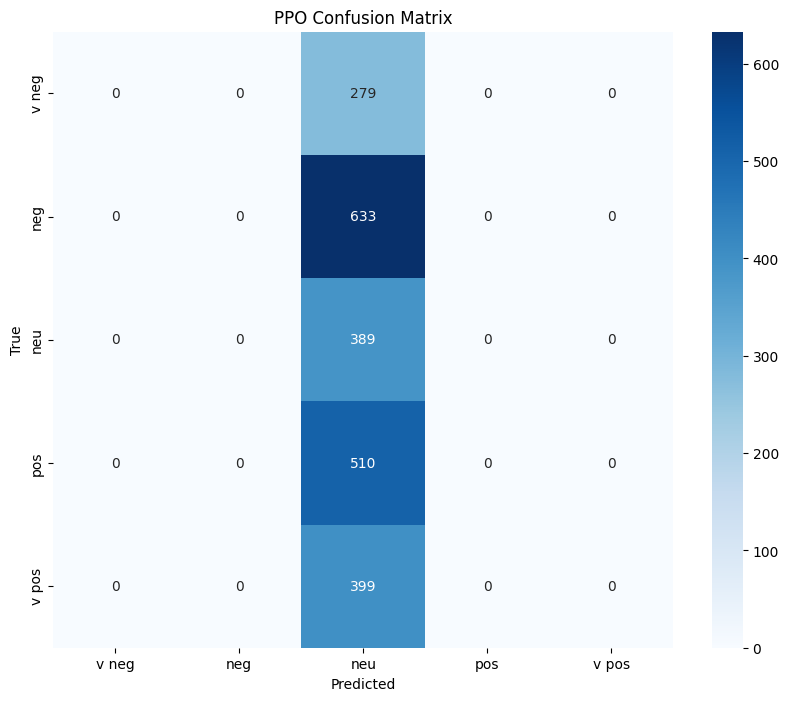

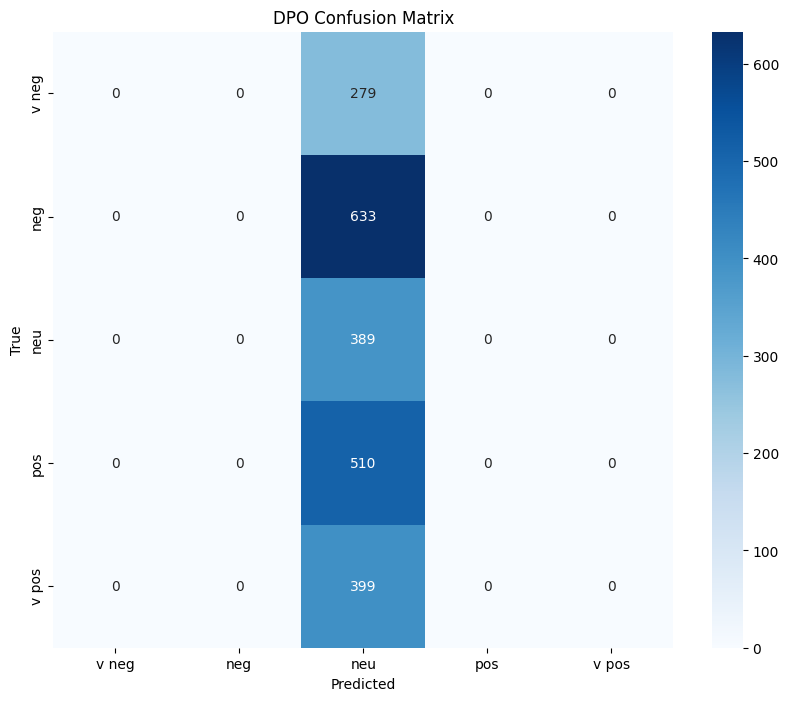


PPO Model Metrics per Class:
very negative: Precision=0.0000, Recall=0.0000, F1=0.0000
negative: Precision=0.0000, Recall=0.0000, F1=0.0000
neutral: Precision=0.1760, Recall=1.0000, F1=0.2993
positive: Precision=0.0000, Recall=0.0000, F1=0.0000
very positive: Precision=0.0000, Recall=0.0000, F1=0.0000

DPO Model Metrics per Class:
very negative: Precision=0.0000, Recall=0.0000, F1=0.0000
negative: Precision=0.0000, Recall=0.0000, F1=0.0000
neutral: Precision=0.1760, Recall=1.0000, F1=0.2993
positive: Precision=0.0000, Recall=0.0000, F1=0.0000
very positive: Precision=0.0000, Recall=0.0000, F1=0.0000


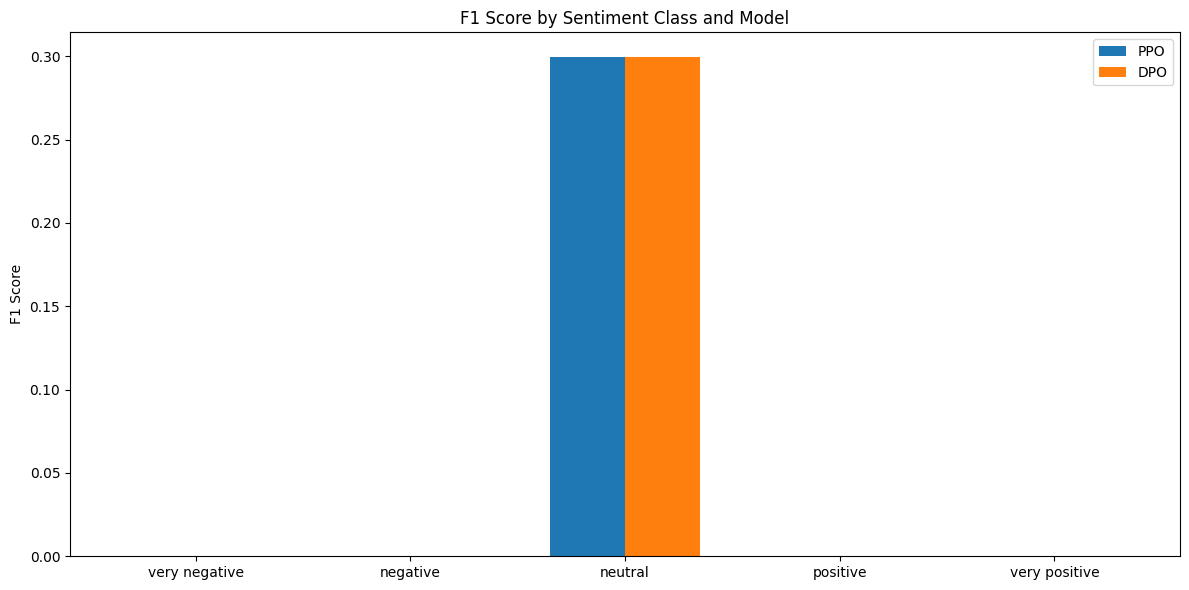

In [11]:
# 10. Phân tích kết quả chi tiết

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["v neg", "neg", "neu", "pos", "v pos"],
                yticklabels=["v neg", "neg", "neu", "pos", "v pos"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(ppo_confusion.cpu().numpy(), 'PPO Confusion Matrix')
plot_confusion_matrix(dpo_confusion.cpu().numpy(), 'DPO Confusion Matrix')

# Calculate per-class metrics
def get_metrics_per_class(confusion):
    cm = confusion.cpu().numpy()
    precision = np.zeros(5)
    recall = np.zeros(5)
    f1 = np.zeros(5)

    for i in range(5):
        # Precision: TP / (TP + FP)
        precision[i] = cm[i, i] / (cm[:, i].sum() + 1e-10)

        # Recall: TP / (TP + FN)
        recall[i] = cm[i, i] / (cm[i, :].sum() + 1e-10)

        # F1: 2 * (precision * recall) / (precision + recall)
        f1[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i] + 1e-10)

    return precision, recall, f1

ppo_precision, ppo_recall, ppo_f1 = get_metrics_per_class(ppo_confusion)
dpo_precision, dpo_recall, dpo_f1 = get_metrics_per_class(dpo_confusion)

# Print metrics per class
sentiment_labels = ["very negative", "negative", "neutral", "positive", "very positive"]
print("\nPPO Model Metrics per Class:")
for i in range(5):
    print(f"{sentiment_labels[i]}: Precision={ppo_precision[i]:.4f}, Recall={ppo_recall[i]:.4f}, F1={ppo_f1[i]:.4f}")

print("\nDPO Model Metrics per Class:")
for i in range(5):
    print(f"{sentiment_labels[i]}: Precision={dpo_precision[i]:.4f}, Recall={dpo_recall[i]:.4f}, F1={dpo_f1[i]:.4f}")

# Plot comparison of F1 scores
labels = sentiment_labels
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, ppo_f1, width, label='PPO')
rects2 = ax.bar(x + width/2, dpo_f1, width, label='DPO')

ax.set_ylabel('F1 Score')
ax.set_title('F1 Score by Sentiment Class and Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()